<a href="https://colab.research.google.com/github/bernieee/SIRIUS/blob/master/AI_for_Med_image_analysis/Challenge_lungs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!mkdir data64 
!unzip /content/drive/My\ Drive/data64.zip -d data64

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib import image as IMG
import imageio
import PIL
from PIL import Image, ImageEnhance
import torchvision as tv
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale, resize, downscale_local_mean
from pathlib import Path
import torchvision.transforms #import (Compose, ColorJitter, RandomGrayscale, RandomHorizontalFlip, RandomOrder, RandomRotation)

In [ ]:
if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [ ]:
images_path = 'data64/data64'
images_path_new = '/content/drive/My Drive/Sirius challenge/GB7_new'
labels_path = '/content/drive/My Drive/train_new.csv'
test_path = '/content/drive/My Drive/test_2.csv'

## **Prepare train data**

In [ ]:
train_df = pd.read_csv(labels_path)
#train_df

In [ ]:
frontal = list(map(str, train_df[train_df['label']=='frontal']['target_name'])) 
lateral = list(map(str, train_df[train_df['label']=='lateral']['target_name']))

In [ ]:
images = np.concatenate([frontal, lateral])
image_names = []
image_labels = {}

for image in images:
    image_name = images_path + '/' + image
    if image in frontal:
        image_labels.update({image_name: 1})
    else:
        image_labels.update({image_name: 0})
    image_names.append(image_name)

In [ ]:
resized_images = {}

for image_name in image_names:
    resized_images[image_name] = np.asarray(Image.open(image_name).convert("L")) / 256

(64, 64)


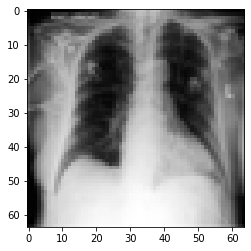

In [ ]:
for i, k in enumerate(resized_images):
    if i == 0:
        print(resized_images[k].shape)
        plt.imshow(resized_images[k], cmap='gray')
        break

In [ ]:
class LungsClassificationDataset(Dataset):
    def __init__(self, image_names, resized_images, image_labels, transformations=None):
        self.image_names = image_names
        self.resized_images = resized_images
        self.image_labels = image_labels
        self.transformations = transformations
                                            
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, index):
        image_path = self.image_names[index]

        #image_0 = self.resized_images[image_path]
        image = Image.open(image_path)
        label = self.image_labels[image_path]

        if self.transformations:
            image = self.transformations(image)
        
        image = (np.asarray(image.convert("L")) / 256) ** 0.4

        image = torch.tensor(image)
        label = torch.tensor(label)

        result = {"image":image,"label":label}
        return result

In [ ]:
train_image_names, val_image_names = train_test_split(image_names, test_size=0.2)
transform = torchvision.transforms.Compose([torchvision.transforms.ColorJitter(), torchvision.transforms.RandomHorizontalFlip(p=0.5)])

train = LungsClassificationDataset(train_image_names, resized_images, image_labels, transformations=transform)
validation = LungsClassificationDataset(val_image_names, resized_images, image_labels, transformations=transform)

In [ ]:
imageWidth, imageHeight = train[0]['image'].shape

In [ ]:
for i in range(len(train)):
    sample = train[i]
    plt.imshow(sample['image'], cmap='gray')
    plt.show()
    print(sample['label'])

tensor(1)


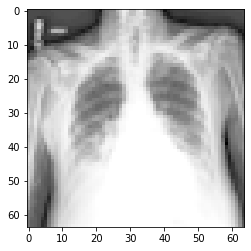

In [ ]:
sample = train[22]
plt.imshow(sample['image'], cmap='gray')
print(sample['label'])

In [ ]:
len(validation)

640

## **Model Architecture**

In [ ]:
class LungModel(nn.Module):
    def __init__(self,width,height): 
        super(LungModel,self).__init__()  

        numConvs1 = 8
        numConvs2 = 16
        numConvs3 = 32
        numConvs4 = 64
        convSize = 3
       
        self.cnv1 = nn.Conv2d(in_channels=1, out_channels=numConvs1, kernel_size=convSize)
        self.cnv2 = nn.Conv2d(in_channels=numConvs1, out_channels=numConvs2, kernel_size=convSize)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnv3 = nn.Conv2d(in_channels=numConvs2, out_channels=numConvs3, kernel_size=convSize)
        self.cnv4 = nn.Conv2d(in_channels=numConvs3, out_channels=numConvs4, kernel_size=convSize)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        denseSize1 = 512
        denseSize2 = 100
      
        self.dense1 = nn.Linear(64*13*13, denseSize1)
        self.dense2 = nn.Linear(denseSize1, denseSize2)
        self.dense3 = nn.Linear(denseSize2, 1)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):

        x = F.elu(self.cnv1(x))
        x = F.elu(self.cnv2(x))
        x = self.maxpool1(x)
        x = F.elu(self.cnv3(x))
        x = F.elu(self.cnv4(x))
        x = self.maxpool2(x)
        x = x.view(-1,self.num_flat_features(x))
        x = F.elu(self.dense1(x)) 
        x = self.dropout(x)
        x = F.elu(self.dense2(x)) 
        x = self.dropout(x)
        x = self.dense3(x)        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model = LungModel(imageWidth, imageHeight).to(dev)

In [ ]:
train_loader = DataLoader(train, batch_size=50, shuffle=True, drop_last=True)
val_loader = DataLoader(validation, batch_size=50, shuffle=True, drop_last=True)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
import time
print(time.time())

1596808134.1346724


In [ ]:
num_epochs = 20

t = time.time() 

for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    time_start = time.time()

    for sample_idx, sample in enumerate(train_loader):
        image, label = sample['image'].unsqueeze(1).float(), sample['label'].unsqueeze(1).float()
        image, label = image.to(dev), label.to(dev)

        prediction = model(image)

        optimizer.zero_grad()
        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step() 

        train_loss += loss.item()

        if sample_idx % 100 == 0:
            print(loss.item())

    val_loss = 0
    model.eval()

    with torch.no_grad():
        for sample in val_loader:
            image, label = sample['image'].unsqueeze(1).float(), sample['label'].unsqueeze(1).float()
            image, label = image.to(dev), label.to(dev)
            prediction = model(image)

            optimizer.zero_grad()
            loss = criterion(prediction, label)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch: {epoch}; Time Epoch: {time.time() - time_start}\nTraining Loss: {train_loss}\nValidation Loss: {val_loss}\n-----")


0.6943725347518921
Epoch: 0; Time Epoch: 3.057464838027954
Training Loss: 0.3085531925819084
Validation Loss: 0.07693945864836375
-----
0.1060628890991211
Epoch: 1; Time Epoch: 3.063638210296631
Training Loss: 0.07609097486106205
Validation Loss: 0.04744618587816755
-----
0.036799896508455276
Epoch: 2; Time Epoch: 3.044053316116333
Training Loss: 0.06566770639562723
Validation Loss: 0.05733107375757148
-----
0.010827493853867054
Epoch: 3; Time Epoch: 3.041855573654175
Training Loss: 0.05388151689469084
Validation Loss: 0.04201114103974154
-----
0.043853916227817535
Epoch: 4; Time Epoch: 3.0145163536071777
Training Loss: 0.04276705788466714
Validation Loss: 0.03640345297753811
-----
0.004824346397072077
Epoch: 5; Time Epoch: 3.0239477157592773
Training Loss: 0.03186891116110571
Validation Loss: 0.025056977717516322
-----
0.04616490378975868
Epoch: 6; Time Epoch: 2.982327461242676
Training Loss: 0.02534497195316077
Validation Loss: 0.029856469191145152
-----
0.04055313393473625
Epoch: 7;

## **Prepare test data**

In [ ]:
test_df = pd.read_csv(test_path)
test_df

,target_name
0,patient00012study2view2.png
1,patient00016study1view2.png
2,patient00023study2view2.png
3,patient00023study9view2.png
4,patient00080study7view2.png
...,...
1205,36190_1.2.826.0.1.3680043.2.634.0.55819.201652...
1206,36201_1.2.826.0.1.3680043.2.634.0.20266.201652...
1207,36229_1.2.826.0.1.3680043.2.634.0.15889.201653...
1208,36244_1.2.826.0.1.3680043.2.634.0.11543.201653...


In [ ]:
images = list(map(str, test_df['target_name']))
test_image_names = []
i = 0
new_dir = '/content/drive/My Drive/GB7'

for image in images:
    if i < 800:
        image_name = images_path + '/' + image
    else:
        image_name = new_dir + '/' + image
    i += 1

    test_image_names.append(image_name)

In [ ]:
nTestData = len(test_image_names)
nTestData

1210

In [ ]:
'''
new_dir = '/content/drive/My Drive/GB7'
i = 0

for image_name in images:
    if i >= 800:
        img = Image.open(images_path_new + '/' + image_name)
        array_img = np.array(img) // 256
        inverse_img = PIL.ImageOps.invert(Image.fromarray(array_img).convert('L'))
        new_img = inverse_img.resize((64, 64))
        new_img.save(f"{new_dir}/{image_name}")
    i += 1
    print(i, end=' ')
'''

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [ ]:
resized_images = {}
i = 0

for image_name in test_image_names:
    if i >= 800:
        resized_images[image_name] = (np.asarray(Image.open(image_name).convert("L")) / 256)
    else:
        resized_images[image_name] = (np.asarray(Image.open(image_name).convert("L")) / 256) ** 0.5 
    i += 1
    print(i, end=' ')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [ ]:
ans = []

model.eval()

with torch.no_grad():
    for k in resized_images:
        #print(resized_images[k].shape)
        image = torch.tensor(resized_images[k]).unsqueeze(0).unsqueeze(0).float()
        image = image.to(dev)
        #print(image.shape)
        prediction = model(image)
        prediction = torch.sigmoid(prediction)

        ans.append(prediction.item())
        print(prediction.item())                    

1.4252293681513824e-21
2.7197428548991613e-16
2.0465255682839756e-17
2.9858229028069307e-16
1.1783734578385552e-11
6.628849653119796e-20
8.575687035494717e-12
0.25863000750541687
4.454114621620445e-14
6.103892348161e-13
1.1547873768336103e-09
3.5855719435207156e-12
3.584807797829548e-11
1.9472243262264044e-11
9.352065433176904e-08
7.608697780093877e-17
4.946992468446432e-11
3.841952189821354e-17
4.852723752620403e-15
3.132518116427674e-13
7.986057972587262e-16
5.825994686681213e-10
0.9174296855926514
4.430168237871913e-15
6.445018997658369e-12
3.428843368835795e-16
3.042446123594639e-14
1.0666062651154551e-11
9.443891890725808e-09
8.225708342609432e-17
2.905653148643772e-11
3.4476980732139895e-12
1.26572472121389e-12
3.435942289797822e-06
1.265135186282601e-13
4.1974887107776304e-15
1.1456433674991717e-13
3.0046167771963805e-17
1.283774301796887e-17
6.184482685946206e-17
2.303013682536381e-12
1.5329533432570375e-12
1.1169720476236072e-13
8.893743243425299e-16
6.91463352504515e-14
2.668

In [ ]:
test_df.insert(1, 'label', ans)

In [ ]:
test_df

,target_name,label
0,patient00012study2view2.png,1.425229e-21
1,patient00016study1view2.png,2.719743e-16
2,patient00023study2view2.png,2.046526e-17
3,patient00023study9view2.png,2.985823e-16
4,patient00080study7view2.png,1.178373e-11
...,...,...
1205,36190_1.2.826.0.1.3680043.2.634.0.55819.201652...,8.867755e-13
1206,36201_1.2.826.0.1.3680043.2.634.0.20266.201652...,2.152238e-11
1207,36229_1.2.826.0.1.3680043.2.634.0.15889.201653...,2.223252e-19
1208,36244_1.2.826.0.1.3680043.2.634.0.11543.201653...,1.329116e-14


In [ ]:
test_df.to_csv(r'ans_csv.csv')